# The Sed object

This example demonstrates the various methods associated with the `Sed` class.

`Sed` objects can be extracted directly from `Grid` objects or created by `Galaxy` objects. See tutorials on those objects for more information.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr
import os
from unyt import Angstrom, Hz, um
from synthesizer.grid import Grid, get_available_lines
from synthesizer.sed import Sed
from synthesizer.filters import FilterCollection

Let's begin by initialising a grid:

In [2]:

grid_dir =  '../../tests/test_grid/'
grid_name = 'test_grid'
grid = Grid(grid_name, grid_dir=grid_dir)

In [3]:
grid_dir =  '/Users/sw376/Dropbox/Research/data/synthesizer/grids/'
grid_name = 'bpass-2.3-bin_chabrier03-0.1,300.0_alpha0.2_cloudy-c17.03_resolution:0.1'
grid = Grid(grid_name, grid_dir=grid_dir)

Next, let's define a target log10age and metallicity and use the built-in `Grid` method to get the grid point and then extract the spectrum for that grid point.

In [4]:
log10age = 6. # log10(age/yr)
metallicity = 0.01 
spec_name = 'incident'
grid_point = grid.get_grid_point((log10age, metallicity))
sed = grid.get_sed(grid_point, spec_name=spec_name)

Like other `synthesizer` objects, we get some basic information about the `Sed` object by using the `print` command:

In [5]:
print(sed)

----------
SUMMARY OF SED 
Number of wavelength points: 82248 
Wavelength range: [0.00 Å, 299742000000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)): 21.56 
log10(Bolometric luminosity/erg/s): 36.85 
----------


`Sed` objects contain a wavelength grid and luminosity in the `lam` and `lnu` attributes. Both come with units making them easy to convert:

In [6]:
print(sed.lam)
print(sed.lnu)

[1.24543e-04 1.24917e-04 1.25293e-04 ... 2.99543e+11 2.99643e+11
 2.99742e+11] Å
[0. 0. 0. ... 0. 0. 0.] erg/(Hz*s)


Thus we can easily make a plot:

/Users/sw376/.local/lib/python3.11/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


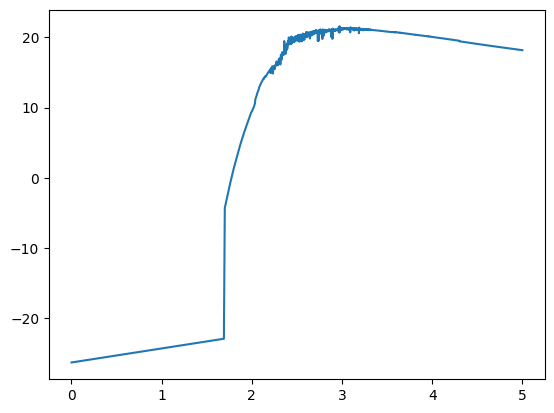

In [7]:
plt.plot(np.log10(sed.lam), np.log10(sed.lnu))

### Methods

#### get_bolometric_luminosity()

This method allows us to calculate the bolometric luminosity of the sed. 

In [8]:
sed.measure_bolometric_luminosity()

unyt_quantity(7.01111209e+36, 'erg/s')

By default the above simply sums up the spectrum. However, we can also integrate the spectrum instead:

In [9]:
sed.measure_bolometric_luminosity(method='quad')

/Users/sw376/Dropbox/Research/projects/synthesizer/synthesizer/sed.py:130: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  bolometric_luminosity = integrate.quad(self._get_lnu_at_nu,


unyt_quantity(7.02444114e+36, 'erg/s')

Under-the-hood the above uses a function to get the luminosity at a particular frequency or wavelength:

In [10]:
sed.get_lnu_at_lam(1500 * Angstrom)

unyt_quantity(1.55802527e+21, 'erg/(Hz*s)')

In [11]:
sed.get_lnu_at_nu(1E14 * Hz)

unyt_quantity(1.30295797e+19, 'erg/(Hz*s)')

In [12]:
sed.measure_window_luminosity((1400.*Angstrom,1600.*Angstrom))

unyt_quantity(4.06558265e+35, 'erg/s')

In [13]:
sed.measure_window_luminosity((0.14*um,0.16*um))

unyt_quantity(4.06558265e+35, 'erg/s')

In [14]:
sed.measure_window_lnu((1400.*Angstrom,1600.*Angstrom))

unyt_quantity(1.51898495e+21, 'erg/(Hz*s)')

In [15]:
sed.measure_window_lnu((1400.*Angstrom,1600.*Angstrom), method='average')

unyt_quantity(1.51898773e+21, 'erg/(Hz*s)')

In [16]:
sed.measure_window_lnu((1400, 1600)*Angstrom, method='quad')

/Users/sw376/Dropbox/Research/projects/synthesizer/synthesizer/sed.py:348: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Lnu = integrate.quad(func, *lims)[0] / \


unyt_quantity(1.51911292e+21, 'erg/(Hz*s)')

We can also measure a spectral break by providing two windows, e.g.

In [17]:
sed.measure_break((3400, 3600) * Angstrom, (4150, 4250) * Angstrom)

unyt_quantity(0.85692253, '(dimensionless)')

There are also a few in-built break methods, e.g. `measure_Balmer_break()`

In [18]:
sed.measure_balmer_break()

unyt_quantity(0.85692253, '(dimensionless)')

In [19]:
sed.measure_d4000()

unyt_quantity(0.90162194, '(dimensionless)')

We can also measure absorption line indices:

In [20]:
sed.measure_index((1500,1600)*Angstrom, (1400,1500)*Angstrom, (1600,1700)*Angstrom)

unyt_quantity(5.02853716, 'Å')

We can also measure the UV spectral slope $\beta$:

In [21]:
sed.measure_beta()

-2.9429328476042964

By default this uses a single window and fits the spectrum by a power-law. However, we can also specify two windows as below, in which case the luminosity in each window is calcualted and used to infer a slope:

In [22]:
sed.measure_beta(window=(1250,1750,2250,2750))

-2.949521784273928

## Observed frame SED

To do this we need to provide a cosmology, using an `astropy.cosmology` object, a redshift $z$, and optionally an IGM absorption model.

In [33]:
from astropy.cosmology import Planck18 as cosmo
z = 10.  # redshift
sed.get_fnu(cosmo, z, igm=Madau())  # generate observed frame spectra

unyt_array([0., 0., 0., ..., 0., 0., 0.], 'nJy')

## Broadband fluxes

Once we have computed the observed frame SED there is a method on an `Sed` object that allows us to calculate broadband fluxes. However, first we need to instantiate a `FilterCollection` object.

In [24]:
filter_codes = [f'JWST/NIRCam.{f}' for f in ['F070W','F090W', 'F115W', 'F150W',
                                             'F200W', 'F277W', 'F356W', 'F444W']]  # define a list of filter codes
fc = FilterCollection(filter_codes, new_lam=grid.lam)

In [25]:
# measure broadband fluxes
fluxes = sed.get_broadband_fluxes(fc)

# print broadband fluxes
for filter, flux in fluxes.items():
    print(f'{filter}: {flux:.2f}')

JWST/NIRCam.F070W: 0.00 nJy
JWST/NIRCam.F090W: 0.00 nJy
JWST/NIRCam.F115W: 0.00 nJy
JWST/NIRCam.F150W: 0.00 nJy
JWST/NIRCam.F200W: 0.00 nJy
JWST/NIRCam.F277W: 0.00 nJy
JWST/NIRCam.F356W: 0.00 nJy
JWST/NIRCam.F444W: 0.00 nJy


## Multiple SEDs

The `Sed` object can actually hold an array of seds and the methods should all work fine.

Let's create an `Sed` object with two seds:

In [26]:
sed2 = Sed(sed.lam, np.array([sed.lnu, sed.lnu * 2]))

In [27]:
sed2.measure_window_lnu((1400,1600)*Angstrom)

unyt_array([1.51898495e+21, 3.03796989e+21], 'erg/(Hz*s)')

In [28]:
sed2.measure_window_lnu((1400,1600)*Angstrom, method='average')

unyt_array([1.51898773e+21, 3.03797547e+21], 'erg/(Hz*s)')

In [29]:
sed2.measure_beta()

array([-2.94293285, -2.94293285])

In [30]:
sed2.measure_beta(window=(1250,1750,2250,2750))

array([-2.94952178, -2.94952178])

In [31]:
sed2.measure_balmer_break()

unyt_array([0.85692253, 0.85692253], '(dimensionless)')

In [32]:
sed2.measure_index((1500,1600)*Angstrom, (1400,1500)*Angstrom, (1600,1700)*Angstrom)

unyt_array([5.02853716, 5.02853716], 'Å')